# **Analyst Consensus Model** - Capstone Project: DWS - ESADE Business School

#### **Tutor:** Jarrid Klug
#### **Members:** Alex Casas, Daniel Pace, Enric Aletà

### **Introduction**

The goal of this project is to develop a robust model to evaluate the accuracy of analyst predictions. By analyzing historical predictions and their realized values, we aim to rank analysts based on their performance and construct a weighted consensus ("smart") estimate that outperforms simple averaging methods. This approach can provide valuable insights for decision-making and improve the reliability of aggregated forecasts.

**Note:**  
The dataset used in this project is **synthetic**, created to simulate real-world scenarios due to the unavailability of actual data. However, the methodology and preprocessing steps are designed to closely mimic how real data would be handled, ensuring the approach is transferable to real-world applications.

In [1]:
import pandas as pd
# df = pd.read_csv("data/forecasts.csv")
df = pd.read_csv("data/forecasts_hetero2.csv")
print(df.shape)
df.head()

(13744263, 12)


,Quarter,Estimate Type,Predicted Value,Real Value,Company,Analyst,Bank,Market Cap,Sector,Start Date,Horizon,Revision Time
0,Q1 2013,Stock Price,3.083182e+01,2.906252e+01,Company5,Analyst513,Credit Suisse,Mid Cap,Technology,2013-02-19,Q0,Initial
1,Q1 2013,Stock Price,3.657365e+01,2.906252e+01,Company5,Analyst513,Morgan Stanley,Mid Cap,Technology,2013-02-19,Q1,Initial
2,Q1 2013,Stock Price,4.628826e+01,2.906252e+01,Company5,Analyst513,Barclays,Mid Cap,Technology,2013-02-19,Q2,Initial
3,Q1 2013,EBITDA,1.291998e+09,1.264608e+09,Company5,Analyst513,Barclays,Mid Cap,Technology,2013-02-19,Q0,Initial
4,Q1 2013,EBITDA,1.221465e+09,1.264608e+09,Company5,Analyst513,JP Morgan,Mid Cap,Technology,2013-02-19,Q1,Initial


In [2]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import RidgeCV
import matplotlib.pyplot as plt

# we choose 200 analysts at random (to avoid blowing up RAM)
N_ANALYSTS = 200
rng = np.random.default_rng(42)
all_analysts = df["Analyst"].unique()
sampled_analysts = rng.choice(all_analysts, size=N_ANALYSTS, replace=False)

# build small “pilot” DataFrame
df = df[df["Analyst"].isin(sampled_analysts)].copy()
print(f"Pilot sample rows: {len(df)}, unique analysts: {df['Analyst'].nunique()}")
print(df.shape)

Pilot sample rows: 3818667, unique analysts: 200
(3818667, 12)


We first define a mapping from textual quarter labels (e.g., `"Q2 2016"`) to actual calendar dates (last business day of each quarter):

Let $\mathcal{T} = \{t_1, \dots, t_D\}$ be the list of business days from January 1, 2013 to January 1, 2023. Then for each quarter $Q_k$, define the **quarter-end date**:

$$
\text{QuarterEndsMap}[Q_k] = \max\{ t \in \mathcal{T} \mid t \in Q_k \}.
$$

This mapping allows us to timestamp revision windows and compute time-to-target features.

In [3]:
# Build the quarter_ends_map (if using time-based splits)
# Define quarter-end mapping
start_date = pd.Timestamp("2013-01-01")
end_date = pd.Timestamp("2023-01-01")
trading_days = pd.date_range(start_date, end_date, freq='B')  # Business days
quarter_ends = trading_days.to_series().groupby(trading_days.to_period("Q")).last().values
quarter_ends = pd.to_datetime(quarter_ends)

quarter_ends_map = {
    f"Q{d.quarter} {d.year}": d
    for d in quarter_ends
}

Each forecast is assigned a **revision bucket** based on its distance to the quarter-end date:
- `"Rev 3m"`: 3 months before end of quarter
- `"Rev 2m"`: 2 months before
- `"Rev 1m"`: 1 month before

We define a numerical feature:

$$
\text{RevMonths}_i =
\begin{cases}
3 & \text{if RevBucket}_i = \text{"Rev 3m"} \\
2 & \text{if RevBucket}_i = \text{"Rev 2m"} \\
1 & \text{if RevBucket}_i = \text{"Rev 1m"}
\end{cases}
$$

This encodes how far in advance the forecast was made.

In addition, let $p_i$ be the predicted value and $y_i$ the actual value. We define the **percent error** as:

$$
e_i = \frac{|p_i - y_i|}{|y_i| + \varepsilon}
\quad,\quad \varepsilon = 10^{-6}.
$$

This becomes our target variable `PctErr` for regression.

In [4]:
# Preprocess the data and compute PctErr
from support_functions import assign_rev_bucket

# We filter rows with non-null Real Value
df_reg = df[df["Real Value"].notnull()].copy()

# We assign revision buckets and map to numeric months
df_reg = assign_rev_bucket(df_reg, quarter_ends_map)
df_reg["RevMonths"] = df_reg["RevBucket"].map({"Rev 3m": 3, "Rev 2m": 2, "Rev 1m": 1})

# Compute percentage error (PctErr) as the target variable
EPS = 1e-6
df_reg["PctErr"] = (
    (df_reg["Predicted Value"] - df_reg["Real Value"]).abs() 
    / (df_reg["Real Value"].abs() + EPS)
)

print("\nTraining rows:", len(df_reg))
print("\nSample of the data:")
print(df_reg[["Company", "Analyst", "Estimate Type", "Horizon", "RevBucket", "PctErr"]].head())


Training rows: 2843729

Sample of the data:
        Company     Analyst Estimate Type Horizon RevBucket    PctErr
4312  Company33  Analyst487   Stock Price      Q0    Rev 1m  0.013847
4315  Company33  Analyst487   Stock Price      Q1    Rev 1m  0.068907
4317  Company33  Analyst487   Stock Price      Q2    Rev 1m  0.030113
4320  Company33  Analyst487        EBITDA      Q0    Rev 1m  0.010531
4322  Company33  Analyst487        EBITDA      Q1    Rev 1m  0.046343


We also compute the average percent error over all their forecasts:

$$
\text{Score}_a = \frac{1}{|I_a|} \sum_{i \in I_a} e_i
$$

where $I_a$ is the set of indices for forecasts made by analyst $a$. This value is stored as `Analyst_Performance_Score`. Of course, this won't be used to predict the target since it would lead to **data leakage**. This is just for exploratory purposes.

In [5]:
# Refine Analyst Performance Metric
# Compute mean PctErr for each analyst
analyst_performance = df_reg.groupby("Analyst")["PctErr"].mean().rename("Analyst_Performance_Score")

# Merge the performance score back into the main DataFrame
df_reg = df_reg.merge(analyst_performance, on="Analyst", how="left")

# Drop the old Analyst_Performance column if it exists
if "Analyst_Performance" in df_reg.columns:
    df_reg = df_reg.drop(columns=["Analyst_Performance"])

# Verify the new feature
print("\nSample of refined Analyst Performance Scores:")
print(df_reg[["Analyst", "Analyst_Performance_Score"]].drop_duplicates().head(10))


Sample of refined Analyst Performance Scores:
         Analyst  Analyst_Performance_Score
0     Analyst487                   0.282938
574    Analyst79                   0.243653
614   Analyst213                   0.388374
1420  Analyst177                   0.191724
1477  Analyst582                   0.288162
2644  Analyst211                   0.201436
2700  Analyst215                   0.309541
4326   Analyst66                   0.231313
4341  Analyst361                   0.422051
4460  Analyst453                   0.210933


We construct a feature matrix $X \in \mathbb{R}^{N \times d}$ with one-hot encoded categorical variables and the following numerical features:
- $\text{RevMonths}_i$

Let $e \in \mathbb{R}^N$ be the vector of percent errors. The **Ridge regression** problem is:

$$
\hat{\beta} = \arg\min_{\beta \in \mathbb{R}^d} \left\{
\sum_{i=1}^N \left( e_i - X_i^\top \beta \right)^2 + \alpha \|\beta\|_2^2
\right\}
$$

In [6]:
# Prepare the sparse design matrix

# Ensure the RevBucket column exists
if "RevBucket" not in df_reg.columns:
    rev_bucket_output = assign_rev_bucket(df_reg, quarter_ends_map)
    if isinstance(rev_bucket_output, pd.DataFrame):
        df_reg["RevBucket"] = rev_bucket_output["RevBucket"]
    else:
        df_reg["RevBucket"] = rev_bucket_output
    print("Recomputed RevBucket column.")

# Ensure the RevMonths column exists
if "RevMonths" not in df_reg.columns:
    df_reg["RevMonths"] = df_reg["RevBucket"].map({"Rev 3m": 3, "Rev 2m": 2, "Rev 1m": 1})
    print("Recomputed RevMonths column.")

# Refine Analyst Performance Metric (ensure it's created before using as a feature)
if "Analyst_Performance_Score" not in df_reg.columns:
    analyst_performance = df_reg.groupby("Analyst")["PctErr"].mean().rename("Analyst_Performance_Score")
    df_reg = df_reg.merge(analyst_performance, on="Analyst", how="left")
    print("Computed Analyst_Performance_Score.")

# === Additional preprocessing enhancements ===

# Clip extreme PctErr values (top 1%)
df_reg["PctErr"] = df_reg["PctErr"].clip(upper=df_reg["PctErr"].quantile(0.99))

# Replace rare Analysts and Companies with "Other" to reduce high cardinality
min_count = 100
for col in ["Analyst", "Company"]:
    top_categories = df_reg[col].value_counts()
    rare_categories = top_categories[top_categories < min_count].index
    df_reg[col] = df_reg[col].where(~df_reg[col].isin(rare_categories), other="Other")


# Define categorical columns including interaction terms
cat_cols = [
    "Sector",
    "Market Cap",
    "Estimate Type",
    "Horizon",
   ]

# Set up a sparse one-hot encoder
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse

ohe = OneHotEncoder(
    categories="auto",
    drop=None,
    sparse_output=True,
    handle_unknown="ignore"
)

# Fit and transform categorical features
X_cat_sp = ohe.fit_transform(df_reg[cat_cols])
print("\nEncoded categorical features → sparse matrix:", X_cat_sp.shape)

# Convert numeric feature (RevMonths) to sparse format
X_num_sp = sparse.csr_matrix(df_reg[["RevMonths"]].values)
print("\nNumeric feature → sparse matrix:", X_num_sp.shape)

# Combine categorical and numeric features into a single sparse matrix
X_sp = sparse.hstack([X_cat_sp, X_num_sp], format="csr")
print("\nFinal sparse design matrix X_sp:", X_sp.shape)

# Define the target variable
y = df_reg["PctErr"].to_numpy()
print("\nTarget variable shape (y):", y.shape)


Encoded categorical features → sparse matrix: (2843729, 18)

Numeric feature → sparse matrix: (2843729, 1)

Final sparse design matrix X_sp: (2843729, 19)

Target variable shape (y): (2843729,)


In [8]:
# Define alpha grid for RidgeCV
alphas = np.logspace(-2, -1, num=50)  # Grid of alpha values
print("\nAlpha grid for RidgeCV:")
print(alphas)


Alpha grid for RidgeCV:
[0.01       0.01048113 0.01098541 0.01151395 0.01206793 0.01264855
 0.01325711 0.01389495 0.01456348 0.01526418 0.01599859 0.01676833
 0.01757511 0.0184207  0.01930698 0.0202359  0.02120951 0.02222996
 0.02329952 0.02442053 0.02559548 0.02682696 0.02811769 0.02947052
 0.03088844 0.03237458 0.03393222 0.0355648  0.03727594 0.0390694
 0.04094915 0.04291934 0.04498433 0.04714866 0.04941713 0.05179475
 0.05428675 0.05689866 0.05963623 0.06250552 0.06551286 0.06866488
 0.07196857 0.0754312  0.07906043 0.08286428 0.08685114 0.09102982
 0.09540955 0.1       ]


In [9]:
from sklearn.linear_model import RidgeCV

# we pick a reproducible random 5% sample of our rows
rng = np.random.default_rng(42)
idx = rng.choice(df_reg.index, size=int(len(df_reg)*0.05), replace=False)

X_sub = X_sp[idx]
y_sub = y[idx]

# then run RidgeCV on the small batch
ridge_sub = RidgeCV(
    alphas=alphas,
    cv=5,
    scoring="neg_mean_absolute_error",
    fit_intercept=True,
    store_cv_results=False
)
print("Fitting RidgeCV on subsample of shape", X_sub.shape)
ridge_sub.fit(X_sub, y_sub)
print("Best α on subsample:", ridge_sub.alpha_)

Fitting RidgeCV on subsample of shape (142186, 19)
Best α on subsample: 0.1


In [10]:
from sklearn.linear_model import Ridge

# Re‐fit full‐data Ridge with α found on the subsample
ridge_full = Ridge(
    alpha=ridge_sub.alpha_,
    solver="sag",
    max_iter=1000,
    tol=1e-3,
    random_state=42
)
ridge_full.fit(X_sp, y)

Ridge(alpha=0.1, max_iter=1000, random_state=42, solver='sag', tol=0.001)

The magnitude of each coefficient $|\hat{\beta}_j|$ reflects the importance of feature $j$ in predicting forecast error.

- Top 15 features by $|\hat{\beta}_j|$ are visualized in a bar plot.
- Features with $|\hat{\beta}_j| < 0.05$ are considered low-importance.


Top 15 features by importance:
Horizon_Q0                   0.029351
Horizon_Q2                   0.028471
Sector_Consumer Goods        0.021938
Estimate Type_Stock Price    0.008279
Estimate Type_EBITDA         0.005975
Estimate Type_EBIT           0.005576
Estimate Type_Revenue        0.005172
Sector_Energy                0.004892
Sector_Technology            0.004552
Sector_Industrial            0.003485
Sector_Real Estate           0.003479
Sector_Healthcare            0.003478
Sector_Finance               0.002052
Estimate Type_EPS            0.001901
Horizon_Q1                   0.000879
dtype: float64

Features with |coef| < 0.05:
['Horizon_Q0', 'Horizon_Q2', 'Sector_Consumer Goods', 'Estimate Type_Stock Price', 'Estimate Type_EBITDA', 'Estimate Type_EBIT', 'Estimate Type_Revenue', 'Sector_Energy', 'Sector_Technology', 'Sector_Industrial', 'Sector_Real Estate', 'Sector_Healthcare', 'Sector_Finance', 'Estimate Type_EPS', 'Horizon_Q1', 'Market Cap_Small Cap', 'Market Cap_Large Ca

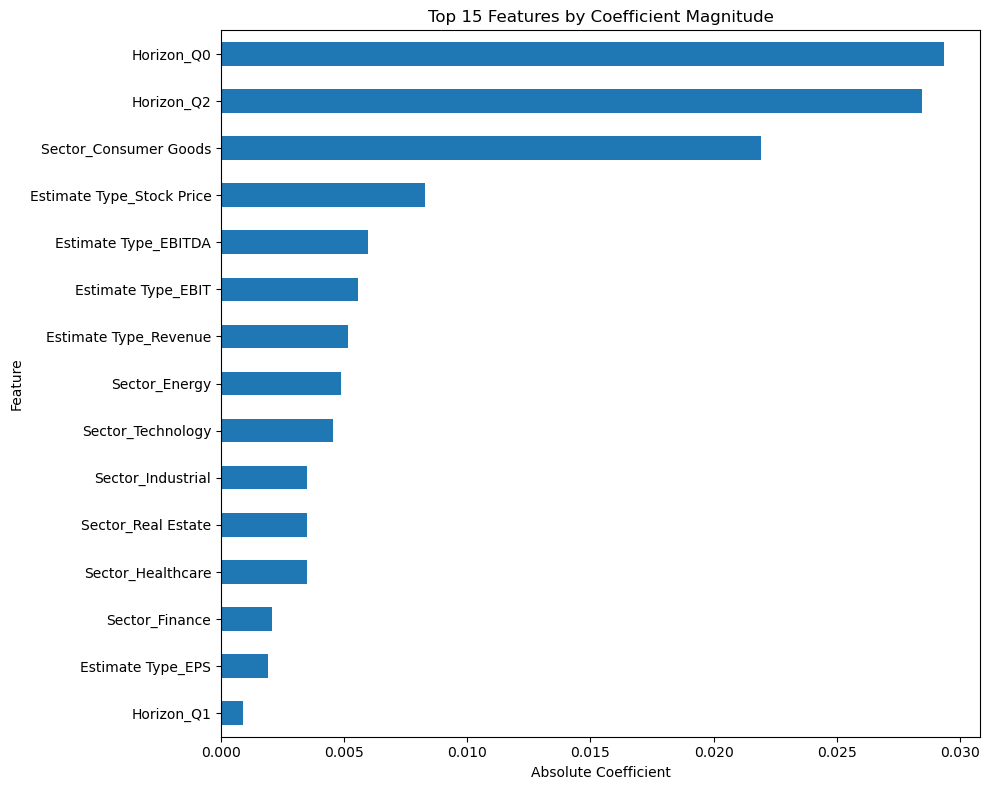

In [11]:
# Analyze feature importance
encoded_feature_names = ohe.get_feature_names_out(cat_cols)
full_feature_names = list(encoded_feature_names) + ["RevMonths"]

# Build a Series of absolute coefficient values
coef = pd.Series(ridge_full.coef_, index=full_feature_names)
sorted_coef = coef.abs().sort_values(ascending=False)

print("\nTop 15 features by importance:")
print(sorted_coef.head(15))

# Identify “low‐importance” features below your threshold
threshold = 0.05
low_importance_features = sorted_coef[sorted_coef < threshold].index.tolist()
print(f"\nFeatures with |coef| < {threshold}:")
print(low_importance_features)

# Visualize the top 15
plt.figure(figsize=(10, 8))
sorted_coef.head(15).plot(kind="barh")
plt.title("Top 15 Features by Coefficient Magnitude")
plt.xlabel("Absolute Coefficient")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [14]:
# Evaluate the model (predict on the same dataset or use a validation/test set)
y_pred = ridge_full.predict(X_sp)

# Compute Mean Absolute Error (MAE)
mae = np.mean(np.abs(y - y_pred))
print(f"\nMean Absolute Error (MAE): {mae:.4f}")


Mean Absolute Error (MAE): 0.0735


**Ridge regression** was chosen due to its computational efficiency, ease of implementation, and interpretability. Its L2 regularization helps mitigate overfitting and multicollinearity while still allowing us to identify feature importance through coefficient magnitudes. This made Ridge a suitable first exploratory model, helping us establish a performance baseline and gain intuition about the structure of the data.

However, Ridge regression imposes **several limitations**. Most importantly, it assumes a linear relationship between features and the target, making it poorly suited to capture nonlinearities or interaction effects that may exist between variables such as analyst identity, sector, or forecast timing. Additionally, Ridge uses global coefficients that do not adapt to firm-specific dynamics or heterogeneous analyst behavior.

To overcome these shortcomings and move beyond the linear regime, we now transition to more flexible, tree-based machine learning models. These will allow us to better model nonlinear patterns, incorporate complex interactions, and ultimately improve the reliability and accuracy of our consensus construction framework.

## Model Selection

To improve the quality of analyst forecast aggregation, we pursue two complementary modeling strategies:

- **Supervised Learning**: Our main objective is to predict the **percentage forecast error** of each analyst prediction, allowing us to assign weights based on forecast quality.
- **Unsupervised Learning** *(explored later)*: Used for clustering analysts by behavioral patterns.

In this section, we focus on supervised learning by training regression models on historical forecast data to estimate:

$$
\text{PctErr}_i = \frac{|p_i - y_i|}{|y_i| + \varepsilon}, \quad \varepsilon = 10^{-6}
$$

Here, $p_i$ is the predicted value and $y_i$ is the actual realized value for forecast $i$.

## Supervised Learning: Forecast Error Estimation

We represent each analyst prediction as a feature vector $\mathbf{x}_i \in \mathbb{R}^d$ including:

- One-hot encoded variables: $\text{Sector}_i$, $\text{MarketCap}_i$, $\text{EstimateType}_i$, $\text{Horizon}_i$
- A numerical feature: $\text{RevMonths}_i$ (months in advance)
- A target variable: $\text{PctErr}_i$ (percentage forecast error)

We evaluate predictive performance using **Time Series Cross-Validation** (`TimeSeriesSplit`), which preserves the temporal structure of the data. Unlike standard k-fold CV, which randomly shuffles the dataset, `TimeSeriesSplit` ensures that each training fold only uses **past data** to predict the **future**. This is essential in time-dependent forecasting tasks.

To preserve the temporal structure of analyst forecasts, we use **Time Series Cross-Validation** via `TimeSeriesSplit` with $k=5$ splits.

In this method, each fold's **training set contains only data from the past**, while the **test set contains data from a future period**, ensuring no data leakage and enabling evaluation of forecast generalization over time.

The splits grow the training window over time. Mathematically, for $k$ splits and a dataset of size $N$, the data is partitioned as:

- Fold 1: Train on $[0, n_1)$, Test on $[n_1, n_2)$  
- Fold 2: Train on $[0, n_2)$, Test on $[n_2, n_3)$  
- ...  
- Fold $k$: Train on $[0, n_k)$, Test on $[n_k, N)$

Where each $n_i$ denotes the increasing boundaries for the test sets.

For example, with $N=100$ rows and $k=5$, the splits look like:

| Fold | Train Indices      | Test Indices      |
|------|--------------------|-------------------|
| 1    | 0–15               | 16–31             |
| 2    | 0–31               | 32–47             |
| 3    | 0–47               | 48–63             |
| 4    | 0–63               | 64–79             |
| 5    | 0–79               | 80–99             |

Each test set $T_j$ represents a **future period** relative to the training set $S_j$. This ensures the models learn only from **past data**, mimicking real forecasting conditions and enabling reliable out-of-sample performance evaluation.

This structure is critical in financial time series to avoid forward-looking bias and to assess how well a model can generalize when facing unseen future estimates.

### Evaluation Metrics

Let $e_i$ be the true percentage error and $\hat{e}_i$ the model prediction. We compute:

- **Mean Absolute Error (MAE)**:
  $$
  \text{MAE} = \frac{1}{N} \sum_{i=1}^{N} |\hat{e}_i - e_i|
  $$

- **Root Mean Squared Error (RMSE)**:
  $$
  \text{RMSE} = \sqrt{ \frac{1}{N} \sum_{i=1}^{N} (\hat{e}_i - e_i)^2 }
  $$

- **Coefficient of Determination ($R^2$)**:
  $$
  R^2 = 1 - \frac{ \sum_{i=1}^{N} (\hat{e}_i - e_i)^2 }{ \sum_{i=1}^{N} (e_i - \bar{e})^2 }
  $$

These metrics are computed on each fold and then averaged to assess overall model quality.

### Models Used

We evaluate two **nonlinear tree-based models**:

#### Random Forest Regressor

Random Forest builds an ensemble of $T$ regression trees, each trained on a random subsample of the data. Each tree $t$ produces an estimate $\hat{e}_i^{(t)}$, and the final prediction is the average:

$$
\hat{e}_i = \frac{1}{T} \sum_{t=1}^{T} \hat{e}_i^{(t)}
$$

Key properties:

- Reduces overfitting via **bagging** (bootstrap aggregation)
- Can model nonlinear relationships and high-cardinality interactions

Settings used:
- $T = 50$ trees
- $\text{max depth} = 10$
- $\text{max samples per tree} = 50\%$ of training data

#### Gradient Boosting Regressor

Gradient Boosting sequentially fits additive models to correct the residuals of previous models. The prediction after $T$ iterations is:

$$
\hat{e}_i = \sum_{t=1}^{T} \eta \cdot f_t(\mathbf{x}_i)
$$

where:
- $f_t(\cdot)$ is a weak learner (a regression tree)
- $\eta$ is the learning rate controlling step size

At each step, $f_t$ is fit to the negative gradient of the loss function:

$$
r_i^{(t)} = -\frac{\partial \mathcal{L}(e_i, \hat{e}_i^{(t-1)})}{\partial \hat{e}_i}
$$

Settings used:
- $T = 50$ boosting rounds
- $\eta = 0.1$ (learning rate)
- $\text{max depth} = 5$

> **Note:**  
> The hyperparameters used for both models (number of trees, depth, learning rate, sample size, etc.) were set to reasonable defaults based on empirical experience and literature guidance. In this initial stage, we intentionally avoided an exhaustive hyperparameter search to reduce computational overhead and maintain tractability during model comparison.  
>
> In future iterations, we plan to perform systematic hyperparameter optimization to improve predictive performance and robustness.

In [15]:
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# draw a reproducible subsample (up to 1 000 000 rows)
rng = np.random.default_rng(42)
desired = 1_000_000
n_cv = min(desired, X_sp.shape[0])           # <- cap at the number of available rows
idx_cv = rng.choice(X_sp.shape[0], size=n_cv, replace=False)
X_cv = X_sp[idx_cv]
y_cv = y[idx_cv]

# set up the time‐series split & scoring metrics
tscv = TimeSeriesSplit(n_splits=5)
scoring = {
    "MAE": "neg_mean_absolute_error",
    "RMSE": "neg_mean_squared_error",
    "R2": "r2"
}

# define models (use max_samples to save memory)
models = {
    "Random Forest": RandomForestRegressor(
        n_estimators=50,
        max_depth=10,
        max_samples=0.5,      # sample 50% of each fold
        random_state=42,
        n_jobs=1
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=50,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
}

# run cross_validate on the subsample
for name, model in models.items():
    print(f"Training {name} on a {n_cv:,}-row subsample…")
    scores = cross_validate(
        model,
        X_cv,
        y_cv,
        cv=tscv,
        scoring=scoring,
        n_jobs=1,            # single process to reduce memory pressure
        error_score="raise"
    )
    mae  = -scores["test_MAE"].mean()
    rmse =  np.sqrt(-scores["test_RMSE"]).mean()
    r2   =   scores["test_R2"].mean()
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

Training Random Forest on a 1,000,000-row subsample…
MAE:  0.0724
RMSE: 0.0983
R²:   0.1049
Training Gradient Boosting on a 1,000,000-row subsample…
MAE:  0.0724
RMSE: 0.0982
R²:   0.1055


The **Mean Absolute Error (MAE)** of approximately **7.2%** indicates that, on average, the models’ predictions deviate from the true percentage error by 7.2 percentage points. The **Root Mean Squared Error (RMSE)** is slightly higher (~9.8%), reflecting occasional larger deviations.

The **coefficient of determination ($R^2$)** for both models is around **0.105**, meaning they explain only about **10.5% of the variance** in the forecast error. This modest value is expected in high-variance financial data where many latent factors affect prediction accuracy.

Despite the relatively low $R^2$, the models offer valuable predictive power and can still be effectively used for:

- **Ranking forecasts** by expected error
- **Weighting analyst predictions** based on estimated reliability
- Serving as a **baseline** for future iterations with richer features and better-tuned hyperparameters

After evaluating both models with 5-fold time series CV on a 1M-row subsample, we retrain on the full dataset to maximize generalization. To manage memory:

- **Random Forest** uses `max_samples = 500,000` per tree
- **Gradient Boosting** uses the full training set

These final models will be used to generate **error predictions** $\widehat{e}_i$ for every analyst forecast, enabling downstream tasks such as: 1) Smart forecast weighting and 2) Analyst benchmarking. 

In [17]:
# Re-train final models on the reduced feature set
# Random Forest
rf_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    max_samples=500_000,   # subsample per tree to save memory
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_sp, y)

# Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_sp, y)

GradientBoostingRegressor(max_depth=5, n_estimators=50, random_state=42)

After training our supervised learning models to predict the forecast error (`PctErr`), we use the full dataset to generate analyst performance scores based on **expected accuracy**. We apply the trained **Random Forest (RF)** and **Gradient Boosting (GB)** models to all analyst forecasts in the dataset:

- $\text{PredictedPctErr}^{\text{RF}}_i = \hat{e}_i^{\text{RF}}$ is the predicted error from the Random Forest  
- $\text{PredictedPctErr}^{\text{GB}}_i = \hat{e}_i^{\text{GB}}$ is the predicted error from Gradient Boosting

These values represent the estimated error of each individual forecast.

For each analyst $a$, we compute the **average predicted error** over all their forecasts:

$$
\text{PredictedAvg}_a^{\text{RF}} = \frac{1}{n_a} \sum_{i \in \text{Analyst } a} \hat{e}_i^{\text{RF}}, \quad
\text{PredictedAvg}_a^{\text{GB}} = \frac{1}{n_a} \sum_{i \in \text{Analyst } a} \hat{e}_i^{\text{GB}}
$$

This provides a model-based estimate of how accurate each analyst is on average.

To convert the average predicted errors into **intuitive scores** where higher means better performance, we use a smooth, bounded transformation:

$$
\text{AnalystScore}_a = \frac{1}{1 + \text{PredictedAvg}_a}
$$

This maps predicted average errors to a bounded range between 0 and 1. Analysts with lower expected errors receive higher scores.

Finally, we average these scores for each analyst and construct a ranking table based on their performance:

| Analyst        | AnalystScore_RF | AnalystScore_GB |
|----------------|------------------|------------------|
| Analyst_123    | 0.82             | 0.80             |
| Analyst_456    | 0.79             | 0.78             |
| ...            | ...              | ...              |

This allows us to rank analysts according to the predicted accuracy of their forecasts, supporting downstream decision-making in weighting, coverage optimization, or engagement prioritization.

In [18]:
# Predict PctErr on full data and compute analyst scores
# Generate predictions
df_reg["Predicted_PctErr_RF"] = rf_model.predict(X_sp)
df_reg["Predicted_PctErr_GB"] = gb_model.predict(X_sp)

# Average predicted error per analyst
df_reg["Predicted_Avg_RF"] = (
    df_reg.groupby("Analyst")["Predicted_PctErr_RF"]
    .transform("mean")
)
df_reg["Predicted_Avg_GB"] = (
    df_reg.groupby("Analyst")["Predicted_PctErr_GB"]
    .transform("mean")
)

# Convert avg error into a score (higher = better)
df_reg["Analyst_Score_RF"] = 1 / (1 + df_reg["Predicted_Avg_RF"])
df_reg["Analyst_Score_GB"] = 1 / (1 + df_reg["Predicted_Avg_GB"])

# Build the final ranking table
score_table = (
    df_reg
    .groupby("Analyst")[["Analyst_Score_RF", "Analyst_Score_GB"]]
    .mean()
    .sort_values("Analyst_Score_RF", ascending=False)
)

print(score_table.head(10))

            Analyst_Score_RF  Analyst_Score_GB
Analyst                                       
Analyst525          0.905993          0.906085
Analyst11           0.905796          0.905834
Analyst60           0.905558          0.905540
Analyst198          0.905295          0.905241
Analyst197          0.905054          0.904870
Analyst68           0.904904          0.904862
Analyst439          0.904785          0.904689
Analyst698          0.904683          0.904593
Analyst394          0.904635          0.904767
Analyst274          0.904633          0.904773


count    2.843729e+06
mean     9.018724e-01
std      1.531912e-03
min      8.976617e-01
25%      9.008806e-01
50%      9.020353e-01
75%      9.028435e-01
max      9.059930e-01
Name: Analyst_Score_RF, dtype: float64


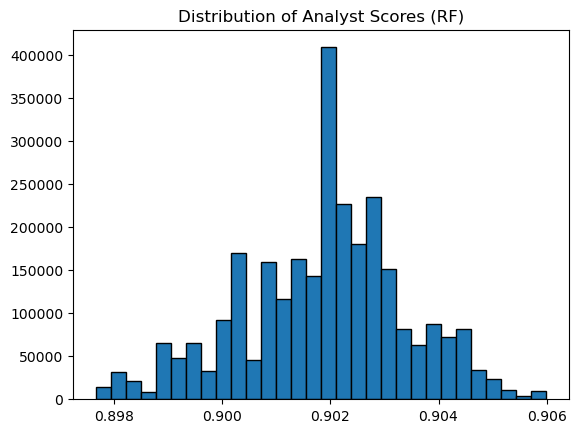

In [19]:
print(df_reg["Analyst_Score_RF"].describe())
plt.hist(df_reg["Analyst_Score_RF"], bins=30, edgecolor="k")
plt.title("Distribution of Analyst Scores (RF)")
plt.show()

## Unsupervised Learning – Clustering Analysts by Forecasting Patterns

To extract latent behavioral patterns among analysts, we apply **unsupervised learning** techniques to group similar analysts into clusters. This allows us to move beyond individual metrics and identify analyst "types" based on their forecasting behavior and feature profiles.

Given our high-dimensional sparse design matrix $X \in \mathbb{R}^{N \times d}$ (with one-hot encoded categorical features and numerical variables), we apply **Truncated Singular Value Decomposition (SVD)** to project it into a lower-dimensional space:

$$
X_{\text{svd}} = X \cdot W \in \mathbb{R}^{N \times r}
$$

where $r \ll d$ and $W$ is the matrix of top $r$ right singular vectors. This step helps:

- Eliminate noise and sparsity
- Accelerate clustering
- Reveal latent structure in the data

We use:
- $r = 10$ for final clustering
- $r = 5$ for silhouette scoring (faster)

We run **MiniBatch K-Means** for $k \in \{2, 3, ..., 8\}$ and evaluate clustering quality using the **Silhouette Score**:

$$
s_i = \frac{b_i - a_i}{\max(a_i, b_i)}
$$

where:
- $a_i$ is the average distance of sample $i$ to other points in the same cluster
- $b_i$ is the average distance to points in the nearest neighboring cluster

The overall silhouette score is the average $s_i$ over a sample of observations. We select:

$$
k^\star = \arg\max_k \text{SilhouetteScore}(k)
$$

Once the optimal number of clusters $k^\star$ is selected, we re-fit MiniBatch K-Means on the full 10-dimensional SVD-transformed data to obtain final cluster assignments:

$$
\text{AnalystCluster}_i = \text{KMeans}(X_{\text{svd},i})
$$

We assign these cluster labels to each analyst’s forecasts to interpret behavior at the group level.

To understand the quality and character of each cluster, we compute:

- **Mean percentage error** within each cluster:
  $$
  \text{ClusterAvgError}_k = \frac{1}{n_k} \sum_{i \in \text{Cluster } k} \text{PctErr}_i
  $$
- **Forecast count per cluster** $n_k$

This lets us contrast clusters by accuracy and volume, identifying groups of consistently high- or low-performing analysts.

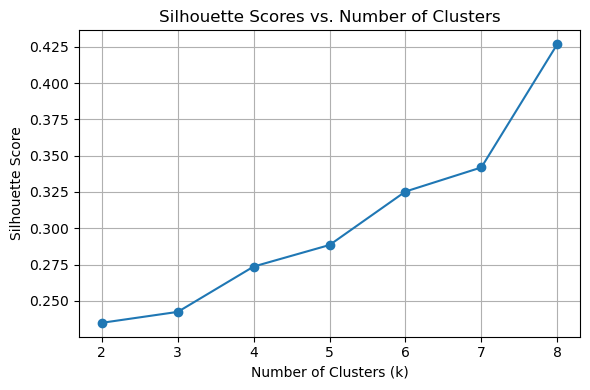


Optimal number of clusters: 8

Assigned analyst clusters:
       Analyst  Analyst_Cluster
0   Analyst487                0
1   Analyst487                7
2   Analyst487                3
18  Analyst487                1
28  Analyst487                5

Cluster performance summary:
                     mean   count
Analyst_Cluster                  
5                0.079961  217527
6                0.080129  259940
0                0.080390  299618
4                0.080770  213295
7                0.110094  495219
1                0.111016  452125
2                0.137438  502017
3                0.138961  403988


In [20]:
# Unsupervised Learning - Clustering Analysts Based on Prediction Patterns
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score

# Reduce dimensionality for clustering (SVD)
svd = TruncatedSVD(n_components=10, random_state=42)
X_svd = svd.fit_transform(X_sp)

# Optional: We can try with fewer components for silhouette scanning (faster)
svd_fast = TruncatedSVD(n_components=5, random_state=42)
X_svd_fast = svd_fast.fit_transform(X_sp)

# Silhouette scan (k from 2 to 8)
silhouette_scores = {}
for k in range(2, 9):
    kmeans_temp = MiniBatchKMeans(n_clusters=k, random_state=42, n_init='auto', batch_size=1024)
    labels = kmeans_temp.fit_predict(X_svd_fast)
    score = silhouette_score(X_svd_fast, labels, sample_size=50000, random_state=42)
    silhouette_scores[k] = score

# Plot silhouette scores
plt.figure(figsize=(6, 4))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
plt.title("Silhouette Scores vs. Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Best k
best_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"\nOptimal number of clusters: {best_k}")

# Final clustering with full 10D embedding
kmeans = MiniBatchKMeans(n_clusters=best_k, random_state=42, n_init='auto', batch_size=1024)
kmeans_labels = kmeans.fit_predict(X_svd)
df_reg["Analyst_Cluster"] = kmeans_labels

print("\nAssigned analyst clusters:")
print(df_reg[["Analyst", "Analyst_Cluster"]].drop_duplicates().head())

# Cluster performance
cluster_perf = df_reg.groupby("Analyst_Cluster")["PctErr"].agg(["mean", "count"]).sort_values("mean")
print("\nCluster performance summary:")
print(cluster_perf)

In [21]:
# Analyze categorical composition
df_reg.groupby("Analyst_Cluster")[["Sector", "Estimate Type", "Horizon"]].agg(lambda x: x.value_counts().index[0])

,Sector,Estimate Type,Horizon
Analyst_Cluster,,,
0,Industrial,Stock Price,Q0
1,Finance,EPS,Q1
2,Consumer Goods,EBITDA,Q2
3,Technology,EBIT,Q2
4,Finance,EPS,Q0
5,Technology,EPS,Q0
6,Real Estate,Stock Price,Q0
7,Technology,EBITDA,Q1


In [22]:
# Remap "Quarter" to datetime using existing map
df_reg["Quarter"] = df_reg["Quarter"].map(quarter_ends_map)

# Now safely convert to quarterly string (like "2021Q1")
df_reg["Quarter_str"] = df_reg["Quarter"].dt.to_period("Q").astype(str)

# Check cluster consistency
cluster_change = df_reg.groupby(["Analyst", "Quarter_str"])["Analyst_Cluster"].nunique()
num_switching = (cluster_change > 1).sum()

print(f"🔄 Analysts switching clusters over time: {num_switching}")

🔄 Analysts switching clusters over time: 4780


## Analyst Cluster Switching Over Time

After transforming each forecast’s `Quarter` into a standard quarterly period (e.g., `"2021Q1"`) and grouping by both `Analyst` and `Quarter`, we assess whether analysts **retain consistent cluster assignments** over time. Specifically, for each analyst-quarter pair, we compute:

$$
\text{ClusterSwitch}_{a,q} = 
\begin{cases}
1 & \text{if analyst } a \text{ is assigned to more than one cluster in quarter } q \\
0 & \text{otherwise}
\end{cases}
$$

We then sum over all analyst-quarter pairs to count how many experienced **cluster switching**:

$$
\text{Total Switching Events} = \sum_{(a,q)} \mathbf{1}\left\{ \text{ClusterSwitch}_{a,q} = 1 \right\}
$$

We found that **4780 analyst-quarter pairs** involved a change in cluster assignment.

This result indicates that analysts are not statically grouped but may **migrate between behavioral clusters** across quarters. Several factors may contribute to this:

- **Dynamic Behavior**: Analysts may adapt their forecasting approach due to changing market conditions, company performance, or strategic shifts in methodology.
  
- **Model Sensitivity / Instability**: If analyst behavior is borderline between clusters, small feature variations may cause the model to reassign clusters, reflecting potential noise or model limitations.

- **Analyst Learning or Decline**: Forecast accuracy may improve or deteriorate over time, causing transitions between performance-based clusters (e.g., from low-performing to high-performing groups or vice versa).

In [23]:
# Cluster Transition Analysis
# Track cluster transitions
transitions = (
    df_reg.sort_values(["Analyst", "Quarter"])
          .groupby("Analyst")["Analyst_Cluster"]
          .apply(lambda x: " → ".join(map(str, x)) if x.nunique() > 1 else None)
          .dropna()
)
print("\n🔁 Analysts who switched clusters and their transitions:")
print(transitions.head(10))

# Compare PctErr before vs. after switching
# Detect first switch quarter per analyst
def get_first_switch_quarter(df):
    df = df.sort_values("Quarter")
    switches = df["Analyst_Cluster"].ne(df["Analyst_Cluster"].shift())
    if switches.sum() > 1:
        return df[switches].iloc[1]["Quarter"]  # first actual switch (not first row)
    else:
        return pd.NaT

switch_dates = (
    df_reg.groupby("Analyst")[["Quarter", "Analyst_Cluster"]]
          .apply(get_first_switch_quarter)
          .dropna()
)

# Assign before/after switch label
df_reg["After_Switch"] = df_reg.apply(
    lambda row: row["Quarter"] > switch_dates.get(row["Analyst"], pd.Timestamp.max), axis=1
)

# Aggregate PctErr
pcterr_summary = (
    df_reg[df_reg["Analyst"].isin(switch_dates.index)]
    .groupby(["Analyst", "After_Switch"])["PctErr"]
    .mean()
    .unstack()
    .dropna()
    .rename(columns={False: "Before_Switch", True: "After_Switch"})
)
pcterr_summary["Delta"] = pcterr_summary["After_Switch"] - pcterr_summary["Before_Switch"]
print("\nPctErr Before vs After Switch (sample):")
print(pcterr_summary.head(10))

# Consistent top performers
consistent_analysts = df_reg.groupby("Analyst")["Analyst_Cluster"].nunique()
top_consistent = (
    df_reg[df_reg["Analyst"].isin(consistent_analysts[consistent_analysts == 1].index)]
    .groupby("Analyst")["PctErr"].mean()
    .sort_values()
    .head(10)
)
print("\n🏅 Top 10 consistent analysts with lowest average PctErr:")
print(top_consistent)


🔁 Analysts who switched clusters and their transitions:
Analyst
Analyst10     6 → 2 → 6 → 7 → 2 → 7 → 2 → 6 → 7 → 2 → 7 → 2 ...
Analyst106    0 → 7 → 3 → 0 → 7 → 3 → 5 → 7 → 3 → 0 → 7 → 0 ...
Analyst11     0 → 1 → 3 → 0 → 1 → 0 → 1 → 0 → 1 → 3 → 0 → 1 ...
Analyst110    6 → 2 → 6 → 1 → 2 → 5 → 1 → 2 → 6 → 1 → 2 → 4 ...
Analyst112    4 → 1 → 4 → 1 → 2 → 4 → 1 → 2 → 4 → 1 → 2 → 4 ...
Analyst113    6 → 2 → 7 → 2 → 5 → 2 → 7 → 6 → 7 → 2 → 6 → 7 ...
Analyst118    0 → 3 → 0 → 7 → 3 → 5 → 3 → 0 → 3 → 7 → 3 → 0 ...
Analyst119    6 → 7 → 2 → 7 → 2 → 6 → 7 → 2 → 6 → 7 → 2 → 6 ...
Analyst120    6 → 7 → 2 → 6 → 2 → 5 → 6 → 2 → 7 → 2 → 6 → 7 ...
Analyst127    1 → 3 → 4 → 2 → 4 → 1 → 2 → 4 → 2 → 4 → 1 → 6 ...
Name: Analyst_Cluster, dtype: object

PctErr Before vs After Switch (sample):
After_Switch  Before_Switch  After_Switch     Delta
Analyst                                            
Analyst10          0.125139      0.114138 -0.011000
Analyst106         0.141837      0.135948 -0.005889
Analyst11

## Cluster Transition Analysis

In this step, we examine how analysts' cluster assignments evolve over time and how those transitions relate to changes in forecast error. The goal is to assess behavioral dynamics, stability, and whether switching clusters is associated with performance improvement or decline.

For each analyst, we track their sequence of cluster assignments across quarters. Given a time-ordered sequence of clusters $(c_1, c_2, \dots, c_T)$, we record transitions such as:

$$
c_1 \rightarrow c_2 \rightarrow \dots \rightarrow c_T
$$

Only analysts who experienced at least one cluster change are included. This highlights analysts with volatile or adaptive forecasting behaviors.

We identify the **first cluster switch** for each analyst, defined as the first time their cluster assignment changes (excluding the initial assignment). Let $t^*$ denote the time of the first switch:

$$
t^* = \min\left\{ t > 1 \mid c_t \neq c_{t-1} \right\}
$$

We then label each forecast as either **Before Switch** ($t < t^*$) or **After Switch** ($t \geq t^*$) and compute average forecast error:

- Before switch:
  $$
  \text{PctErr}_{\text{before}} = \frac{1}{n_{\text{before}}} \sum_{i \in \text{before}} e_i
  $$
- After switch:
  $$
  \text{PctErr}_{\text{after}} = \frac{1}{n_{\text{after}}} \sum_{i \in \text{after}} e_i
  $$

We define the change in error (Delta) as:

$$
\Delta = \text{PctErr}_{\text{after}} - \text{PctErr}_{\text{before}}
$$

- $\Delta < 0$: performance improved after switching clusters
- $\Delta > 0$: performance worsened

We filter analysts who never changed clusters (i.e., cluster uniqueness = 1) and compute their average forecast error:

$$
\text{AvgPctErr}_a = \frac{1}{n_a} \sum_{i \in a} e_i
$$

The lowest values indicate consistent and accurate analysts.

## Final Model: Integrated Analyst Scoring System

We now construct a **hybrid scoring model** that combines both **supervised** and **unsupervised learning** to provide a robust, interpretable, and dynamic scoring of analyst performance.

The scoring system incorporates:

- **Predicted accuracy**: using forecast error predictions from supervised models (Random Forest and Gradient Boosting).
- **Behavioral clustering**: using unsupervised KMeans cluster assignments to adjust scores based on analyst behavior patterns.
- **Rescaling for interpretability**: final scores are normalized to a 0–10 range for practical ranking and dashboard integration.

### Step 1: Cluster-Based Bonus

We first compute the **cluster bonus**, which captures the relative performance of each behavioral cluster. Let:

- $g$ index a cluster
- $\mu_g = \text{mean PctErr in cluster } g$
- $\mu_{\max} = \max_g \mu_g$

Then, define the bonus as:

$$
\text{Bonus}_g = \frac{\mu_{\max} - \mu_g}{\mu_{\max}}
$$

This rewards clusters with lower average forecast error. Analysts in better-performing clusters receive higher bonuses.

### Step 2: Raw Analyst Score (with bonus)

We use predicted average error from each model ($\widehat{e}_i^{\text{RF}}$, $\widehat{e}_i^{\text{GB}}$) to compute base scores:

$$
\text{Score}_{\text{base}} = \frac{1}{1 + \widehat{e}_i}
$$

Then, apply the cluster bonus multiplicatively:

$$
\text{Score}_{\text{raw}} = \text{Score}_{\text{base}} \cdot (1 + \text{Bonus}_g)
$$

Separate scores are computed for RF and GB:

- $\text{Final_Analyst_Score_RF_raw}$
- $\text{Final_Analyst_Score_GB_raw}$

### Step 3: Normalization to [0, 10] Range

To ensure interpretability and comparability, raw scores are rescaled to a 0–10 range:

$$
\text{Final Score} = \frac{\text{Raw Score}}{\max(\text{Raw Scores})} \cdot 10
$$

This gives us:

- $\text{Final_Analyst_Score_RF}$
- $\text{Final_Analyst_Score_GB}$

The final analyst ranking is computed by averaging the normalized scores per analyst:

$$
\text{Final Score}_a = \frac{1}{n_a} \sum_{i \in a} \text{Final Score}_i
$$

The analysts are sorted in descending order based on these aggregated scores.

In [25]:
# Compute Cluster Bonus based on real PctErr performance
cluster_performance = df_reg.groupby("Analyst_Cluster")["PctErr"].mean()
cluster_bonus = (cluster_performance.max() - cluster_performance) / cluster_performance.max()

# Map Cluster Bonus to each row
df_reg["Cluster_Bonus"] = df_reg["Analyst_Cluster"].map(cluster_bonus)

# Calculate Final Adjusted Analyst Scores (raw version)
df_reg["Final_Analyst_Score_RF_raw"] = (1 / (1 + df_reg["Predicted_Avg_RF"])) * (1 + df_reg["Cluster_Bonus"])
df_reg["Final_Analyst_Score_GB_raw"] = (1 / (1 + df_reg["Predicted_Avg_GB"])) * (1 + df_reg["Cluster_Bonus"])

# Rescale scores to 0–10 range
max_rf = df_reg["Final_Analyst_Score_RF_raw"].max()
max_gb = df_reg["Final_Analyst_Score_GB_raw"].max()

df_reg["Final_Analyst_Score_RF"] = (df_reg["Final_Analyst_Score_RF_raw"] / max_rf) * 10
df_reg["Final_Analyst_Score_GB"] = (df_reg["Final_Analyst_Score_GB_raw"] / max_gb) * 10

# Final Ranking Table
final_score_table = (
    df_reg.groupby("Analyst")[["Final_Analyst_Score_RF", "Final_Analyst_Score_GB"]]
          .mean()
          .sort_values("Final_Analyst_Score_RF", ascending=False)
)

print("\n🏅 Final Analyst Scores (scaled out of 10) (sample):")
final_score_table


🏅 Final Analyst Scores (scaled out of 10) (sample):


,Final_Analyst_Score_RF,Final_Analyst_Score_GB
Analyst,,
Analyst525,8.657386,8.657386
Analyst497,8.644628,8.647015
Analyst698,8.621016,8.619277
Analyst573,8.608608,8.608061
Analyst11,8.606329,8.605825
...,...,...
Analyst56,8.461444,8.461564
Analyst214,8.458354,8.459554
Analyst361,8.457618,8.457486


We implement a dynamic dashboard that summarizes the performance of any individual analyst across multiple dimensions. The goal is to provide a **comprehensive, interpretable, and diagnostic view** of an analyst’s behavior, strengths, and weaknesses using their **final adjusted scores** derived from the integrated scoring model.

Given an analyst name (e.g., `"Analyst67"`), we extract all their forecasting records and report:

#### 1. Overall Final Scores

We compute the analyst’s average final score from both models:

- **Random Forest Final Score**:
  $$
  \text{Overall}^{\text{RF}}_a = \frac{1}{n_a} \sum_{i \in a} \text{FinalAnalystScore}^{\text{RF}}_i
  $$

- **Gradient Boosting Final Score**:
  $$
  \text{Overall}^{\text{GB}}_a = \frac{1}{n_a} \sum_{i \in a} \text{FinalAnalystScore}^{\text{GB}}_i
  $$

These scores are scaled from 0 to 10 and reflect both the **predicted accuracy** and the **cluster-based behavioral adjustment**.

#### 2. Score Breakdown by Sector

We group the analyst’s forecasts by sector (e.g., Technology, Industrials) and report average scores:

$$
\text{Score}_{a,s} = \frac{1}{n_{a,s}} \sum_{i \in (a,s)} \text{FinalScore}_i
$$

This highlights which **sectors** the analyst performs best in.

#### 3. Score Breakdown by Estimate Type

We break down performance by types of estimates (e.g., EPS, EBITDA):

$$
\text{Score}_{a,e} = \frac{1}{n_{a,e}} \sum_{i \in (a,e)} \text{FinalScore}_i
$$

This reveals whether the analyst is more reliable at certain **financial metrics**.

#### 4. Score Breakdown by Forecast Horizon

We analyze the scores based on the time horizon of the forecasts (e.g., Q0, Q1, FY1):

$$
\text{Score}_{a,h} = \frac{1}{n_{a,h}} \sum_{i \in (a,h)} \text{FinalScore}_i
$$

This helps identify if the analyst excels at **short-term or long-term predictions**.

In [28]:
# Simple Analyst Performance Dashboard

def show_analyst_performance(analyst_name):
    # Filter data
    analyst_data = df_reg[df_reg["Analyst"] == analyst_name]
    
    if analyst_data.empty:
        print(f"⚠️ Analyst '{analyst_name}' not found.")
        return
    
    print(f"\n📊 Performance Summary for {analyst_name}:")
    
    # Overall Final Scores
    overall_rf = analyst_data["Final_Analyst_Score_RF"].mean()
    overall_gb = analyst_data["Final_Analyst_Score_GB"].mean()
    print(f"- Overall Final Score (RF): {overall_rf:.2f} / 10")
    print(f"- Overall Final Score (GB): {overall_gb:.2f} / 10")
    
    # Performance by Sector
    sector_perf = analyst_data.groupby("Sector")[["Final_Analyst_Score_RF", "Final_Analyst_Score_GB"]].mean().sort_values("Final_Analyst_Score_RF", ascending=False)
    print("\n🏢 Performance by Sector:")
    display(sector_perf)
    
    # Performance by Estimate Type
    estimate_perf = analyst_data.groupby("Estimate Type")[["Final_Analyst_Score_RF", "Final_Analyst_Score_GB"]].mean().sort_values("Final_Analyst_Score_RF", ascending=False)
    print("\n🧮 Performance by Estimate Type:")
    display(estimate_perf)
    
    # Performance by Horizon
    horizon_perf = analyst_data.groupby("Horizon")[["Final_Analyst_Score_RF", "Final_Analyst_Score_GB"]].mean().sort_values("Final_Analyst_Score_RF", ascending=False)
    print("\n⏳ Performance by Horizon:")
    display(horizon_perf)

# Example usage
show_analyst_performance("Analyst67")


📊 Performance Summary for Analyst67:
- Overall Final Score (RF): 8.56 / 10
- Overall Final Score (GB): 8.56 / 10

🏢 Performance by Sector:


,Final_Analyst_Score_RF,Final_Analyst_Score_GB
Sector,,
Finance,8.630456,8.629157
Consumer Goods,8.614678,8.613381
Energy,8.577737,8.576446
Healthcare,8.545343,8.544057
Industrial,8.517093,8.515810
Real Estate,8.507538,8.506257



🧮 Performance by Estimate Type:


,Final_Analyst_Score_RF,Final_Analyst_Score_GB
Estimate Type,,
EBIT,8.570288,8.568998
Stock Price,8.569444,8.568153
Revenue,8.569096,8.567806
EBITDA,8.551661,8.550374
EPS,8.547753,8.546466



⏳ Performance by Horizon:


,Final_Analyst_Score_RF,Final_Analyst_Score_GB
Horizon,,
Q0,9.940955,9.939458
Q1,8.419270,8.418002
Q2,7.032087,7.031028
